In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=-1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.3081,2,5,False,True,False
1,2025020076,2025-10-18T17:00:00,Buffalo Sabres,Florida Panthers,0.5602,0.4793,0.3182,3,0,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          196      0.5510 0.2585   0.7117 0.4885   0.5255
Totals (Over/Under)  196      0.4847 0.2514   0.6959 0.5089   0.5357
Asian Handicap       196      0.2908 0.2163   0.6270 0.4982   0.6939


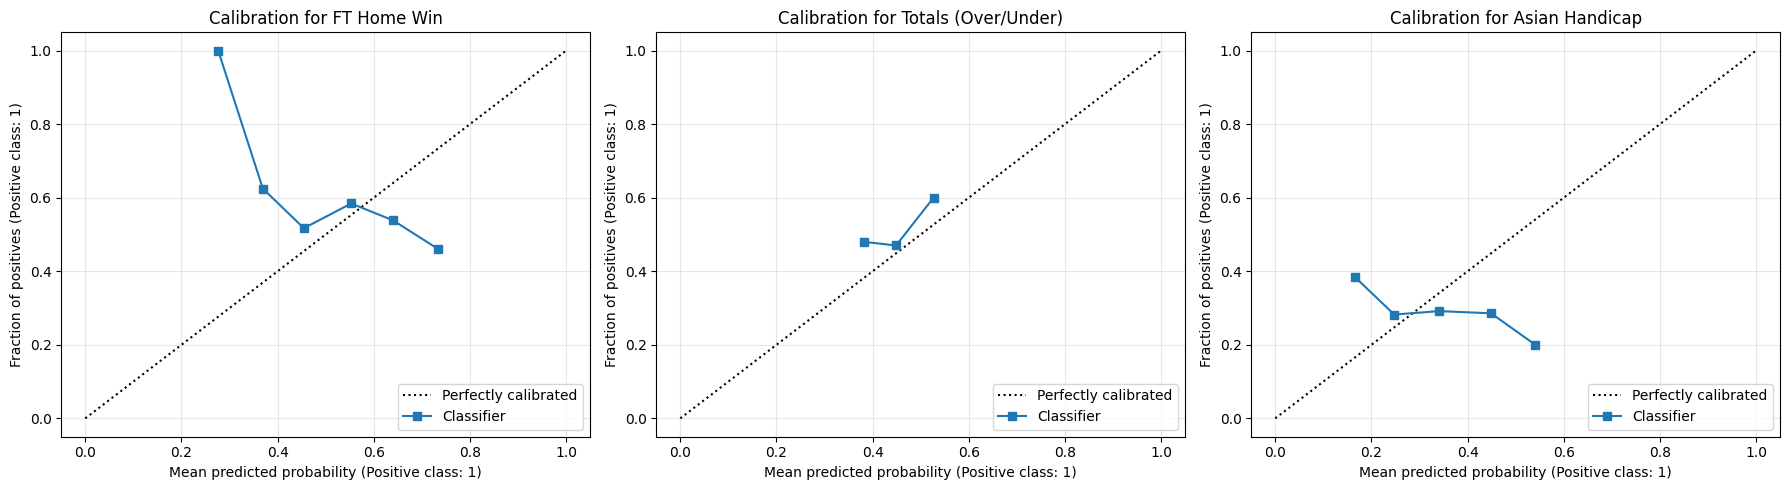

In [7]:
_ = u.evaluate_calibration(df=df, n_bins=10)

## NBA

In [ ]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=-8.5)
df.head(2)

In [ ]:
_ = u.evaluate_calibration(df=df, n_bins=10)

Not enough samples
